In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import collections
import copy
import heapq
import math
import pickle
import random
import time
import os

# 1 Реализация `NAMOA` и `BOA`
## 1.1 Общая часть
- Функция `read_edgelists` строит граф дорожной сети. Парметры: `path_distance_data` - путь к файлу с информацией о расстоянии между соседними вершинами, `path_time_data` - путь к файлу с информацией о времени пути между соседними вершинами. Рёбра нагружены 2 тивами весов: расстоянием между вершинами и временем пути между вершинами. Принимаются фалы соревнования *9th DIMACS Implementation Challenge*, например, `USA-road-d.NY.gr` и `USA-road-t.NY.gr`. Описание форматов файлов: http://www.diag.uniroma1.it/challenge9/format.shtml
- Класс `Node` инкапсулирует информацию о g- и f-значениях вершины, а также информацию о родительской вершине, раскрытие которой привело к созданию узла. Узлы упорядочиваются по f-значению лексикографически.
- Фунция `dominates` задаёт отношение доминирование между кортежами

In [2]:
def read_edgelists(path_distance_data, path_time_data):
    graph = nx.Graph()
    V = None
    E = None
    with open(path_distance_data, 'r') as file_distance_data, open(path_time_data, 'r') as file_time_data:
        for line_distance, line_time in zip(file_distance_data, file_time_data):
            tokens_distance = line_distance.strip().split()
            tokens_time = line_time.strip().split()
            assert tokens_distance[0] == tokens_time[0]
            
            if tokens_distance[0] == 'p':
                V = int(tokens_distance[2])
                assert V == int(tokens_time[2])
                
                E = int(tokens_distance[3])
                assert E == int(tokens_time[3])
            elif tokens_distance[0] == 'a':
                E -= 1
                node1 = int(tokens_distance[1])
                assert node1 == int(tokens_time[1])
                
                node2 = int(tokens_distance[2])
                assert node2 == int(tokens_time[2])
                
                distance = int(tokens_distance[3])
                time = int(tokens_time[3])
                graph.add_edge(node1, node2, distance=distance, time=time)
        
        assert len(graph.nodes()) == V, f'Expected nodes:{V}, actual:{len(graph.nodes())}.'
        assert E == 0, f'Expected: all edges are read, actual:{E} edges aren\'t read.'
    
    return graph


class Node:
    def __init__(self, vertex, g, f, parent):
        super().__init__()
        self.vertex = vertex
        self.g = g
        self.f = f
        self.parent = parent
        self.tuple = (self.vertex, self.g, self.f, self.parent)
    
    def __eq__(self, other):
        return self.tuple == other.tuple
    
    def __hash__(self):
        return hash(self.tuple)
    
    def __lt__(self, other):
        return self.f < other.f
    
    def __repr__(self):
        return f'vertex={self.vertex} g={self.g} f={self.f} parent={self.parent}'


def dominates(p, q):
    return (p[0] < q[0] and p[1] <= q[1]) or (p[0] == q[0] and p[1] < q[1])

## 1.2 Реализация `NAMOA`
- Класс `OpenNAMOA` представляет список узлов - кандидатов на раскрытие - для алгоритма NAMOA. Список реализован с помощью кучи и предоставляет интерфейс для эффективного извлечения лексикографически минимального по f-значению узла. Удаление других элементов из списка происходит ленивым способом: удаляемый элемент помечается удалённым, а фактическое удаление происходит только при извлечении элемента с вершины кучи
- Функция `namoa` реализует алгоритм NAMOA. Принимает на вход граф `graph`- экземпляр класса `networkx.classes.graph.Graph`, `start` - стартовая вершина, `goal` - целевая вершина, `weights` - пара названий атрибутов ребра, которые используются в качестве весов. Функция возвращает словарь с элементами: `solutions` - парето-оптимальное множество весов кротчайших путей из `start` в `goal`, `parent` - множество родительских верших, `n_expansions` - количество совершённых раскрытий вершин при выполнении алгоритма, `runtime`время выполнения в секундах, `max_size_invalid` максимальный размер списка OpenNAMOA с учётом помеченных "удалённых" вершин, `max_size` максимальный размер списка OpenNAMOA без учёта помеченных "удалённых" вершин.

In [3]:
class OpenNAMOA:
    def __init__(self):
        super().__init__()
        self.queue = []
        self.valid_nodes = collections.defaultdict(set)
        self.n_invalid = 0
        self.max_size = 0
        self.max_size_invalid = 0
    
    def is_empty(self):
        return len(self.queue) == self.n_invalid
    
    def _get_valid_nodes(self, node):
        return self.valid_nodes[(node.vertex, node.g)]
    
    def push(self, node):
        self._get_valid_nodes(node).add(node)
        heapq.heappush(self.queue, [node.f, node])
        if len(self.queue) > self.max_size_invalid:
            self.max_size_invalid = len(self.queue)
        
        if len(self.queue) - self.n_invalid > self.max_size:
            self.max_size = len(self.queue) - self.n_invalid
    
    def remove_dominated(self, f):
        for _, node in self.queue:
            valid_nodes = self._get_valid_nodes(node)
            if node not in valid_nodes:
                continue
            
            if dominates(f, node.f):
                valid_nodes.remove(node)
                self.n_invalid += 1
    
    def pop(self):
        _, node = heapq.heappop(self.queue)
        valid_nodes = self._get_valid_nodes(node)
        while node not in valid_nodes:
            self.n_invalid -= 1
            _, node = heapq.heappop(self.queue)
            valid_nodes = self._get_valid_nodes(node)
        
        valid_nodes.remove(node)
        return node
    
    def invalidate(self, vertex, g_values):
        for g in g_values:
            valid_nodes = self.valid_nodes.pop((vertex, g), None)
            if valid_nodes is not None:
                self.n_invalid += len(valid_nodes)


def remove_dominated(g, g_set):
    to_remove = [g_dominated for g_dominated in g_set if dominates(g, g_dominated)]
    for g_dominated in to_remove:
        g_set.remove(g_dominated)
    
    return to_remove


def namoa(graph, start, goal, weights=('distance', 'time'), h0=None, h1=None):
    start_time = time.time()
    n_expansions = 0
    
    solutions = []
    if h0 is None:
        h0 = nx.shortest_path_length(graph, source=goal, weight=weights[0])
    
    if h1 is None:
        h1 = nx.shortest_path_length(graph, source=goal, weight=weights[1])
    
    g_open = collections.defaultdict(set)
    g_close = collections.defaultdict(set)
    
    parent = {(0, 0): set()}
    g_open[start].add((0, 0))
    open_ = OpenNAMOA()
    open_.push(Node(vertex=start, g=(0, 0), f=(h0[start], h1[start]), parent=None))
    
    while not open_.is_empty():
        node = open_.pop()
        g_open[node.vertex].remove(node.g)
        g_close[node.vertex].add(node.g)
        if node.vertex == goal:
            solutions.append(node.g)
            open_.remove_dominated(node.f)
            continue
        
        n_expansions += 1
        for edge in graph.edges(node.vertex, data=True):
            next_vertex = edge[1]
            cost = (edge[2][weights[0]], edge[2][weights[1]])
            next_g = (node.g[0] + cost[0], node.g[1] + cost[1])
            if next_g in g_open[next_vertex] or next_g in g_close[next_vertex]:
                parent[next_g].add(node.g)
                continue
            
            if any(dominates(g, next_g) for g in g_open[next_vertex]) \
                    or any(dominates(g, next_g) for g in g_close[next_vertex]):
                continue
            
            next_f = (next_g[0] + h0[next_vertex], next_g[1] + h1[next_vertex])
            if any(dominates(g, next_f) for g in solutions):
                continue
            
            to_remove = remove_dominated(next_g, g_open[next_vertex])
            open_.invalidate(next_vertex, to_remove)
            
            remove_dominated(next_g, g_close[next_vertex])
            parent[next_g] = set([node.g])
            g_open[next_vertex].add(next_g)
            open_.push(Node(next_vertex, next_g, next_f, parent=None))
    
    return {
        'solutions': solutions,
        'parent': parent,
        'n_expansions': n_expansions,
        'runtime': time.time() - start_time,
        'max_size': open_.max_size,
        'max_size_invalid': open_.max_size_invalid
    }

## 1.3 Реализация `BOA`
- Класс `OpenBOA` представляет список узлов - кандидатов на раскрытие - для алгоритма BOA. Список реализован с помощью кучи и предоставляет интерфейс для эффективного извлечения лексикографически минимального по f-значению узла. Другие операции удаления из списка не реализованы, т.к. алгоритм BOA не требует таких операций
- Функция `boa` реализует алгоритм NAMOA. Принимает на вход граф `graph`- экземпляр класса `networkx.classes.graph.Graph`, `start` - стартовая вершина, `goal` - целевая вершина, `weights` - пара названий атрибутов ребра, которые используются в качестве весов. Функция возвращает словарь с элементами: `solutions` - множество узлов - экземпляров класса `Node` для целевой вершины `goal`, g-значения которых образуют парето-оптимальное множество весов кротчайших путей из `start` в `goal` (оптимальные пути восстанавливаются с помощью атрибута `parent` экземпляров `Node`), `n_expansions` - количество совершённых раскрытий вершин при выполнении алгоритма, `runtime`время выполнения в секундах, `max_size` максимальный размер списка OpenBOA.

In [4]:
class OpenBOA:
    def __init__(self):
        super().__init__()
        self.queue = []
        self.max_size = 0
    
    def __len__(self):
        return len(self.queue)
    
    def __iter__(self):
        return iter(self.queue)
    
    def is_empty(self):
        return len(self.queue) == 0
    
    def push(self, node):
        heapq.heappush(self.queue, node)
        if len(self.queue) > self.max_size:
            self.max_size = len(self.queue)
    
    def pop(self):
        return heapq.heappop(self.queue)


def boa(graph, start, goal, weights=('distance', 'time'), h0=None, h1=None):
    start_time = time.time()
    n_expansions = 0
    solutions = []
    if h0 is None:
        h0 = nx.shortest_path_length(graph, source=goal, weight=weights[0])
    
    if h1 is None:
        h1 = nx.shortest_path_length(graph, source=goal, weight=weights[1])
    
    g1_min = collections.defaultdict(lambda: math.inf)
    open_ = OpenBOA()
    open_.push(Node(vertex=start, g=(0, 0), f=(h0[start], h1[start]), parent=None))
    
    while not open_.is_empty():
        node = open_.pop()
        if node.g[1] >= g1_min[node.vertex] or node.f[1] >= g1_min[goal]:
            continue
        
        g1_min[node.vertex] = node.g[1]
        if node.vertex == goal:
            solutions.append(node)
            continue
        
        n_expansions += 1
        for edge in graph.edges(node.vertex, data=True):
            vertex = edge[1]
            cost = (edge[2][weights[0]], edge[2][weights[1]])
            g = (node.g[0] + cost[0], node.g[1] + cost[1])
            f = (g[0] + h0[vertex], g[1] + h1[vertex])
            if g[1] >= g1_min[vertex] or f[1] >= g1_min[goal]:
                continue
            
            successor = Node(vertex, g, f, parent=node)
            open_.push(successor)
    
    return {
        'solutions': solutions,
        'n_expansions': n_expansions,
        'runtime': time.time() - start_time,
        'max_size': open_.max_size
    }

## 1.4 Наивный алгоритм
- Функция `naive_algorithm` реализует простой алгоритм поиска множества кротчайших путей. Принимает на вход граф `graph`- экземпляр класса `networkx.classes.graph.Graph`, `start` - стартовая вершина, `weights` - пара названий атрибутов ребра, которые используются в качестве весов. Алгоритм ищет множества кротчайших путей из вершины `start` во все вершины графа. Функция возвращает словарь, содержащий парето-оптимальное множество весов кротчайших путей из `start` для каждой вершины графа

Идея алгоритма:
1. Список `open` инициализируется стартовой вершиной. 
2. Если при раскрытии вершины удалось добавить или улучшить кротчайший путь до смежной вершины, то смежная вершина добавляется в список `open`
3. Алгоритм останавливается на пустом списке `open`

In [5]:
def naive_algorithm(graph, start, weights=('distance', 'time')):
    g_value = {vertex: set() for vertex in graph.nodes()}
    g_value[start].add((0, 0))
    open_ = collections.deque([start])
    
    while len(open_) > 0:
        vertex = open_.pop()
        for edge in graph.edges(vertex, data=True):
            next_vertex = edge[1]
            cost = (edge[2][weights[0]], edge[2][weights[1]])
            update = False
            for g in g_value[vertex]:
                g_candidate = (g[0] + cost[0], g[1] + cost[1])
                if g_candidate in g_value[next_vertex] \
                        or any(dominates(next_g, g_candidate) for next_g in g_value[next_vertex]):
                    continue
                
                remove_dominated(g_candidate, g_value[next_vertex])
                g_value[next_vertex].add(g_candidate)
                update = True
            
            if update:
                open_.appendleft(next_vertex)
    
    return g_value

# 2 Проверка корректности реализаций `NAMOA` и `BOA`
##  2.1 Проверка на случайном графе из 1000 вершин
Проверка корректности реализаций `NAMOA` и `BOA` с помощью сравнения с результатами `naive_algorithm` на случайном графе, сгенерированным с помощью библиотеки `NetworkX`.
 - Количество вершин случайного графа - 1000
 - Вероятность создания ребра между вершинами - 0.1
 - Веса рёбер - случайные целые числа от 1 до 1000

In [6]:
V = 1000
random_graph = nx.gnp_random_graph(V, 0.1)
for edge in random_graph.edges():
    random_graph[edge[0]][edge[1]]['distance'] = random.randint(1, 1000)
    random_graph[edge[0]][edge[1]]['time'] = random.randint(1, 1000)

print(f'E={len(random_graph.edges())}')

E=49779


In [7]:
%%time
source = 0
ground_truth = naive_algorithm(random_graph, source)
for goal in tqdm(random_graph.nodes()):
    if goal == source:
        continue
    
    boa_solutions = set([node.g for node in boa(random_graph, source, goal)['solutions']])
    namoa_solutions = set(namoa(random_graph, source, goal)['solutions'])
    if ground_truth[goal] != boa_solutions:
        raise AssertionError('BOA results are inconsistent with ground truth.')
    if ground_truth[goal] != namoa_solutions:
        raise AssertionError('NAMOA results are inconsistent with ground truth.')


CPU times: user 23min 57s, sys: 1.32 s, total: 23min 58s
Wall time: 23min 58s


**Результат:** множества весов кротчайших путей из стартовой вершины во все остальные для `NAMOA`, `BOA` и `naive_algorithm` совпали.

##  2.2 Проверка на подграфе DIMACS из 10000 вершин
Проверка корректности реализаций `NAMOA` и `BOA` с помощью сравнения с результатами `naive_algorithm` на подграфе из 10000 вершин дорожной сети New York из *9th DIMACS Implementation Challenge*.

In [8]:
graph = read_edgelists('data/dimacs/USA-road-d.NY.gr', 'data/dimacs/USA-road-t.NY.gr')
print(f'E={len(graph.edges())}')
print(f'V={len(graph.nodes())}')
print(f'Mean degree:{np.mean([degree for node, degree in graph.degree()])}')

E=365050
V=264346
Mean degree:2.7619105263556096


In [9]:
%%time
source = 20000
V = 10000
nodes = [source] + [edge[1] for i, edge in enumerate(nx.bfs_edges(graph, source=source)) if i < V]
subgraph = graph.subgraph(nodes)
print(f'E={len(subgraph.edges())}')
print(f'V={len(subgraph.nodes())}')
print(f'Mean degree:{np.mean([degree for node, degree in subgraph.degree()])}')

ground_truth = naive_algorithm(subgraph, source)
for goal in tqdm(subgraph.nodes()):
    if goal == source:
        continue
    
    boa_solutions = set([node.g for node in boa(subgraph, source, goal)['solutions']])
    namoa_solutions = set(namoa(subgraph, source, goal)['solutions'])
    if ground_truth[goal] != boa_solutions:
        raise AssertionError('BOA results are inconsistent with ground truth.')
    if ground_truth[goal] != namoa_solutions:
        raise AssertionError('NAMOA results are inconsistent with ground truth.')

E=13582
V=10001
Mean degree:2.716128387161284



CPU times: user 1h 42min 59s, sys: 7.45 s, total: 1h 43min 7s
Wall time: 1h 43min 1s


**Результат:** множества весов кротчайших путей из стартовой вершины во все остальные для `NAMOA`, `BOA` и `naive_algorithm` совпали.

# 3 Сравнение на `NAMOA` и `BOA` на данных DIMACS
- Работа алгоритмов сравнивалась на 100 случайно выбраных парах вершин `pairs.txt` графа дорожной сети New York из *9th DIMACS Implementation Challenge*
```python
import random
N_PAIRS = 100
graph = read_edgelists('data/dimacs/USA-road-d.NY.gr', 'data/dimacs/USA-road-t.NY.gr')
nodes = random.sample(list(graph.nodes), k=2 * N_PAIRS)
with open('pairs.txt', 'w') as file_obj:
    for source, goal in zip(nodes[:N_PAIRS], nodes[N_PAIRS:]):
        file_obj.write(f'{source} {goal}\n')
```

In [10]:
def task_boa(graph, start, goal):
    result = boa(graph, start, goal)
    result['solutions'] = [node.g for node in result['solutions']]
    result['start'] = start
    result['goal'] = goal
    
    return result


def task_namoa(graph, start, goal):
    result = namoa(graph, start, goal)
    result['start'] = start
    result['goal'] = goal
    del result['parent']
    
    return result

##  3.1 `BOA`

In [11]:
%%time
graph = read_edgelists('data/dimacs/USA-road-d.NY.gr', 'data/dimacs/USA-road-t.NY.gr')

start_goal_pairs = []
with open('pairs.txt', 'r') as file_obj:
    for line in file_obj:
        line = line.strip()
        if line:
            start_goal_pairs.append(tuple(int(token) for token in line.split()))


with concurrent.futures.ProcessPoolExecutor(max_workers=7) as executor:
    futures = []
    for start, goal in start_goal_pairs:
        futures.append(executor.submit(task_boa, graph, start, goal))
    
    results = [future.result() for future in concurrent.futures.as_completed(futures), total=len(futures)]    
    with open('boa_results.pickle', 'wb') as file_obj:
        pickle.dump(results, file_obj)

CPU times: user 56.7 s, sys: 1.28 s, total: 58 s
Wall time: 11min 13s


##  3.2 `NAMOA`

In [13]:
%%time
graph = read_edgelists('data/dimacs/USA-road-d.NY.gr', 'data/dimacs/USA-road-t.NY.gr')

start_goal_pairs = []
with open('pairs.txt', 'r') as file_obj:
    for line in file_obj:
        line = line.strip()
        if line:
            start_goal_pairs.append(tuple(int(token) for token in line.split()))


with concurrent.futures.ProcessPoolExecutor(max_workers=7) as executor:
    futures = []
    for start, goal in start_goal_pairs:
        futures.append(executor.submit(task_namoa, graph, start, goal))
    
    results = [future.result() for future in concurrent.futures.as_completed(futures), total=len(futures)]    
    with open('namoa_results.pickle', 'wb') as file_obj:
        pickle.dump(results, file_obj)

CPU times: user 58.4 s, sys: 1.44 s, total: 59.9 s
Wall time: 1h 22min 33s


##  3.3 Пример результатов

In [15]:
with open('boa_results.pickle', 'rb') as file_obj:
    boa_results = pd.DataFrame(pickle.load(file_obj))
    boa_results.set_index(keys=['start', 'goal'], inplace=True)
    boa_results.sort_index(inplace=True)

boa_results.head()

,,solutions,n_expansions,runtime,max_size
start,goal,,,,
581,205448,"[(546183, 909771), (546242, 903812), (546880, ...",26776,4.415459,3690
650,176483,"[(735979, 1306497), (736031, 1305654), (736038...",633558,25.949776,51230
4393,159868,"[(1042436, 2012628), (1042479, 2007985), (1042...",251351,10.954799,21498
15332,150787,"[(443588, 980882), (443589, 980881), (443590, ...",81778,5.236346,12044
23924,263320,"[(492751, 839015), (492754, 837314), (492809, ...",91410,4.976904,15046


In [16]:
with open('namoa_results.pickle', 'rb') as file_obj:
    namoa_results = pd.DataFrame(pickle.load(file_obj))
    namoa_results.set_index(keys=['start', 'goal'], inplace=True)
    namoa_results.sort_index(inplace=True)

namoa_results.head()

,,solutions,n_expansions,runtime,max_size,max_size_invalid
start,goal,,,,,
581,205448,"[(546183, 909771), (546242, 903812), (546880, ...",26776,3.998603,2314,3407
650,176483,"[(735979, 1306497), (736031, 1305654), (736038...",633807,110.397955,34549,44948
4393,159868,"[(1042436, 2012628), (1042479, 2007985), (1042...",251351,46.328172,12115,19007
15332,150787,"[(443588, 980882), (443589, 980881), (443590, ...",81778,50.862343,4753,10047
23924,263320,"[(492751, 839015), (492754, 837314), (492809, ...",91410,17.418110,10134,13726


## 3.4 Сравнение полученных решений
Проверка, что множества решений BOA и NAMOA совпадают.

In [25]:
print(
    'Are solutions same:',
    boa_results.solutions.apply(lambda x: set(x)).equals(namoa_results.solutions.apply(lambda x: set(x)))
)

Are solutions same: True


## 3.5 Сравнение `n_expansion`

In [29]:
boa_results[boa_results['n_expansions'] != namoa_results['n_expansions']]

,,solutions,n_expansions,runtime,max_size
start,goal,,,,
650,176483,"[(735979, 1306497), (736031, 1305654), (736038...",633558,25.949776,51230


In [30]:
namoa_results[boa_results['n_expansions'] != namoa_results['n_expansions']]

,,solutions,n_expansions,runtime,max_size,max_size_invalid
start,goal,,,,,
650,176483,"[(735979, 1306497), (736031, 1305654), (736038...",633807,110.397955,34549,44948


**Результат:** только для 1 пары из 100 количество раскрытий для BOA и NAMOA оказалось различным, причём количество отличается незначительно - менее 0.04%

## 3.6 Статистика
### 3.6.1 Статистика `BOA`
Статистики для количества раскрытий, времени выполнения (в секундах) и максимального размера списка Open.

In [31]:
boa_results.drop(columns=['solutions']).describe(percentiles=[]).T[['min', 'mean', 'max', 'std']].T

,n_expansions,runtime,max_size
min,4.900000e+01,1.801484,28.000000
mean,4.896015e+05,27.873722,21850.900000
max,8.497269e+06,521.712259,240390.000000
std,1.300720e+06,78.389148,36845.529102


### 3.6.2 Статистика `NAMOA`
Статистики для количества раскрытий, времени выполнения (в секундах) и максимального размера списка Open (с учётом и без учёта удалённых узлов).

In [32]:
namoa_results.drop(columns=['solutions']).describe(percentiles=[]).T[['min', 'mean', 'max', 'std']].T

,n_expansions,runtime,max_size,max_size_invalid
min,4.900000e+01,1.619263,22.000000,27.000000
mean,4.896040e+05,189.940944,13674.350000,19005.820000
max,8.497269e+06,4236.250133,149794.000000,205330.000000
std,1.300721e+06,634.725630,23689.873754,31931.085141


**Результат:** 
- NAMOA и BOA делают одинаковое количество раскрытий узлов
- NAMOA работает в среднем в 6.8 раз медленне
- Размер списка Open для алгоритма NAMOA в среднем в 1.15 раз меньше

# 4 Применение `BOA` для поиска множества оптимальных путей
Рассматривается применение `BOA` к задаче поиска оптимальных путей на примере 8-связной карты `duskwood` (https://movingai.com/benchmarks/wc3maps512/index.html) с двумя критериями: минимизация длины пути и максимизация безопасности пути. Безопасность проходимой клетки определяется как расстояние до ближайшей непроходимой клетки.  Безопасность маршрута принимается равной сумме значений метрики безопосности для каждой клетки маршрута.
## 4.1 Реализация необходимого функционала 
- Функция `read_movingai` считывает карту, расположенную по пути `path`, и возвращает карту символов в виде списка строк. Формат карты: https://movingai.com/benchmarks/formats.html.
- Функция `to_image` переводит карту символов `symbol_map` в 3х канальный массив-изображение. Отображение символов в RGB цвета задаётся параметром `color_map`
- Функция `mix_colors` смешивает RGB цвета `color1` и `color2` с весом `value`

In [6]:
def read_movingai(path):
    symbol_map = []
    with open(path, 'r') as file_obj:
        file_obj.readline()
        height = int(file_obj.readline().strip().split()[1])
        width = int(file_obj.readline().strip().split()[1])
        file_obj.readline()
        for row, line in enumerate(file_obj):
            line = line.strip()
            assert len(line) == width, f'row:{row}; expected width:{width}; actual width:{len(line)}'
            symbol_map.append(line)
        
        assert row == width - 1, f'expected height:{height}; actual height:{row + 1}'
    
    return symbol_map


def to_image(
    symbol_map,
    color_map={
        'T': np.array([0, 255, 0], dtype=np.uint8),
        '@': np.zeros(3, dtype=np.uint8),
        '.': 255 * np.ones(3, dtype=np.uint8)
    }
):
    image = np.zeros((len(symbol_map), len(symbol_map[0]), 3), dtype=np.uint8)
    for i, row in enumerate(symbol_map):
        for j, symbol in enumerate(row):
            image[i, j, :] = color_map[symbol]
    
    return image


def mix_colors(value, color1, color2):
    assert 0 <= value <= 1, f'value={value}'
    return np.round(value * color1 + (1 - value) * color2).astype(np.uint8)

- Класс `PassableMap` предоставляет интерфейс для поиска парето-оптимального множества путей между парой проходимых клеток по двум критериям: длинна пути и безопасность.
- Параметры конструктора: `symbol_map` - карта символов, по которой будет построен 8-связный ориентированный граф проходимых клеток; `passable_symbol` - символ проходимой клетки.
- Метод `passable_coordinates` возвращает список координат всех проходимых клеток
- Метод `danger_score` возвращает словарь, ключом которого является координата проходимой клетки, а значением - величина "опасности" клетки: $$\forall v \in V \Rightarrow danger(v) = -safety(v) + \max_{v ^ {*} \in V}{safety(v ^ {*})} + 1,$$ где максимум берётся по всем проходимым клеткам графа. С учётом определения и аддитивности метрик $danger$ и $safety$ по длине пути, максимизация безопасности эквивалентна минимизации опасности. Параметр `normalize` позволяет нормировать метрику опасности на 1.
- Метод `optimal_routes` принимает на вход начальную вершину `start` и целевую `goal` и возвращает можество путей, оптимальное по длине и опасности, а также веса этих путей в виде словаря с ключами `routes` и `costs`.

In [7]:
class PassableMap:
    def __init__(self, symbol_map, passable_symbol='.'):
        super().__init__()
        self.graph = nx.DiGraph()
        self.border = set()
        self.node2coordinates = []
        self.coordinates2node = {}
        
        height = len(symbol_map)
        width = len(symbol_map[0])
        for i, row in enumerate(symbol_map):
            for j, symbol in enumerate(row):
                if symbol != passable_symbol:
                    continue
                
                node_id = self._add_node_if_not_exists((i, j))
                passable_neighbors = []
                discard_row = set()
                discard_column = set()
                for neighbor in self._neighbors8(i, j, height, width):
                    if symbol_map[neighbor[0]][neighbor[1]] == passable_symbol:
                        passable_neighbors.append(neighbor)
                    else:
                        self.border.add(node_id)
                        if i == neighbor[0]:
                            discard_column.add(neighbor[1])
                        elif j == neighbor[1]:
                            discard_row.add(neighbor[0])
                
                for neighbor in passable_neighbors:
                    if neighbor[0] in discard_row or neighbor[1] in discard_column:
                        continue
                    
                    neighbor_id = self._add_node_if_not_exists(neighbor)
                    distance = math.sqrt((neighbor[0] - i) ** 2 + (neighbor[1] - j) ** 2)
                    self.graph.add_edge(node_id, neighbor_id, distance=distance, danger=None)
        
        self.node2danger = self._calculate_danger_score()
        for edge in self.graph.edges(data=True):
            edge[2]['danger'] = self.node2danger[edge[1]]
    
    def _add_node_if_not_exists(self, coordinates):
        if coordinates not in self.coordinates2node:
            self.coordinates2node[coordinates] = len(self.node2coordinates)
            self.node2coordinates.append(coordinates)
        
        return self.coordinates2node[coordinates]
    
    @staticmethod
    def _neighbors8(row, column, height, width):
        neighbors = []
        for i in row - 1, row, row + 1:
            if i < 0 or i >= height:
                continue
            
            for j in column - 1, column, column + 1:
                if j < 0 or j >= width or (i == row and j == column):
                    continue
                
                neighbors.append((i, j))
        
        return neighbors

    @staticmethod
    def _neighbors4(row, column, height, width):
        neighbors = []
        for i in row - 1, row + 1:
            if i < 0 or i >= height:
                continue
            
            neighbors.append((i, column))
        
        for j in column - 1, column + 1:
            if j < 0 or j >= width:
                continue
            
            neighbors.append((row, j))
        
        return neighbors

    def _calculate_danger_score(self):
        danger_score = [math.inf] * len(self.node2coordinates)
        for node_id in self.border:
            danger_score[node_id] = 1
        
        nodes = set(self.border)
        while nodes:
            next_nodes = set()
            for node_id in nodes:
                row, column = self.node2coordinates[node_id]
                for edge in self.graph.edges(node_id):
                    neighbor_id = edge[1]
                    neighbor_row, neighbor_column = self.node2coordinates[neighbor_id]
                    distance = math.sqrt((neighbor_row - row) ** 2 + (neighbor_column - column) ** 2)
                    if danger_score[neighbor_id] > danger_score[node_id] + distance:
                        danger_score[neighbor_id] = danger_score[node_id] + distance
                        next_nodes.add(neighbor_id)
            
            nodes = next_nodes
        
        danger_score = np.asarray(danger_score)
        danger_score = -danger_score + danger_score.max() + 1
        
        return danger_score
    
    def danger_score(self, normalize=True):
        node2danger = self.node2danger.copy()
        if normalize:
            node2danger = node2danger / node2danger.max()
        
        return {coordinates: node2danger[node] for coordinates, node in self.coordinates2node.items()}
    
    def passable_coordinates(self):
        return list(self.node2coordinates)
    
    def _get_route(self, solution):
        route = [self.node2coordinates[solution.vertex]]
        cost = solution.g
        while solution.parent is not None:
            route.append(self.node2coordinates[solution.parent.vertex])
            solution = solution.parent

        return cost, route[::-1]
    
    def optimal_routes(self, start, goal):
        assert start in self.coordinates2node
        assert goal in self.coordinates2node
        
        start = self.coordinates2node[start]
        goal = self.coordinates2node[goal]
        routes = []
        costs = []
        for solution in boa(self.graph, start, goal, weights=('distance', 'danger'))['solutions']:
            cost, route = self._get_route(solution)
            routes.append(route)
            costs.append(cost)
        
        return {'routes': routes, 'costs': costs}

## 4.2 Визуализация карты `duskwood`

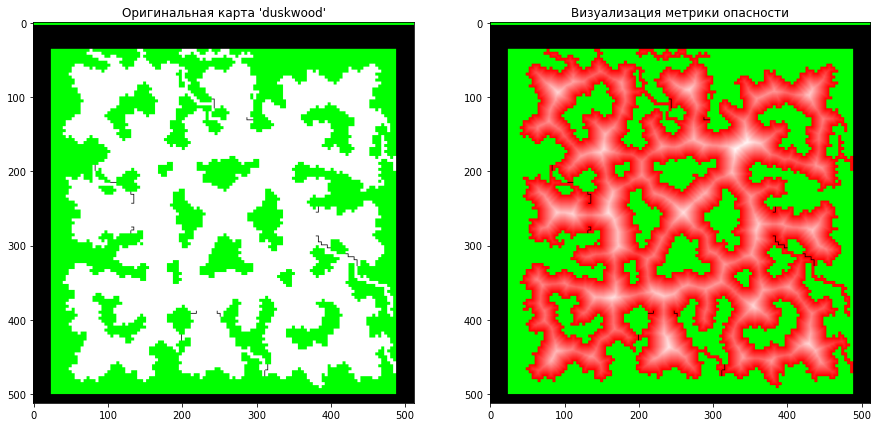

In [8]:
symbol_map = read_movingai('data/movingai/duskwood.map')
passable_map = PassableMap(symbol_map)
danger_score = passable_map.danger_score()

original_map = to_image(symbol_map)
danger_map = original_map.copy()
for row in range(danger_map.shape[0]):
    for column in range(danger_map.shape[1]):
        danger = danger_score.get((row, column), None)
        if danger is not None:
            danger_map[row, column, :] = mix_colors(danger, np.array([255, 0, 0], dtype=np.uint8), np.array([255, 255, 255], dtype=np.uint8))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
ax1.imshow(original_map)
ax2.imshow(danger_map)
ax1.set_title('Оригинальная карта \'duskwood\'')
ax2.set_title('Визуализация метрики опасности')
plt.show()

## 4.3 Построение множества парето-оптимальных маршрутов

In [9]:
start = (100, 110)
goal = (430, 400)

result = passable_map.optimal_routes(start, goal)
print('Количество маршрутов:', len(result['routes']))
for i, route in enumerate(result['routes']):
    print(f'start={route[0]}, goal={route[-1]}, cost={result["costs"][i]}')

Количество маршрутов: 258
start=(100, 110), goal=(430, 400), cost=(516.808224589215, 8759.567886203875)
start=(100, 110), goal=(430, 400), cost=(516.8082245892153, 8471.198261794676)
start=(100, 110), goal=(430, 400), cost=(517.3940110268422, 8462.913990547213)
start=(100, 110), goal=(430, 400), cost=(517.6366517139616, 8449.298766858063)
start=(100, 110), goal=(430, 400), cost=(518.2224381515884, 8441.0144956106)
start=(100, 110), goal=(430, 400), cost=(518.4650788387078, 8427.813485483823)
start=(100, 110), goal=(430, 400), cost=(519.0508652763347, 8419.52921423636)
start=(100, 110), goal=(430, 400), cost=(519.293505963454, 8407.570844796704)
start=(100, 110), goal=(430, 400), cost=(519.8792924010809, 8399.286573549241)
start=(100, 110), goal=(430, 400), cost=(520.1219330882002, 8389.085563422464)
start=(100, 110), goal=(430, 400), cost=(520.7077195258271, 8380.801292175001)
start=(100, 110), goal=(430, 400), cost=(520.9503602129464, 8372.257136297718)
start=(100, 110), goal=(430, 40

## 4.4 Визуализация результатов

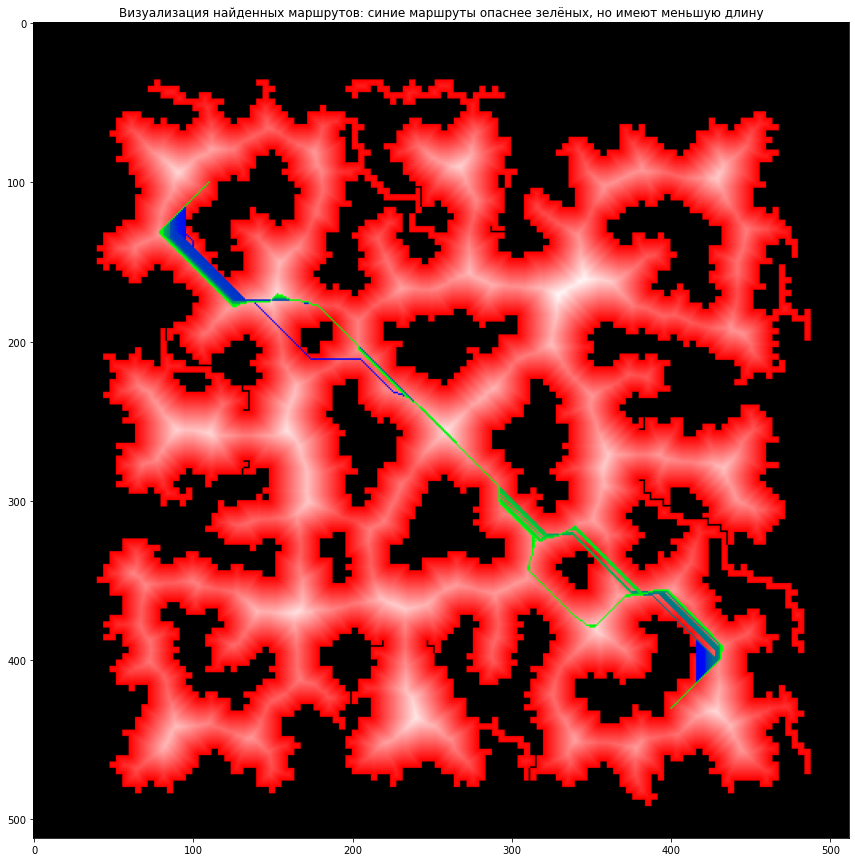

In [10]:
routes_image = danger_map.copy()
routes_image[:, :, 1][routes_image[:, :, 1] == 255] = 0
for i, route in enumerate(result['routes']):
    value = i / (len(result['routes']) - 1)
    for coordinates in route:
        routes_image[coordinates[0], coordinates[1], :] = mix_colors(
            value, np.array([0, 255, 0], dtype=np.uint8), np.array([0, 0, 255], dtype=np.uint8)
        )

plt.figure(figsize=(15, 15))
plt.imshow(routes_image)
plt.title('Визуализация найденных маршрутов: синие маршруты опаснее зелёных, но имеют меньшую длину')
plt.show()

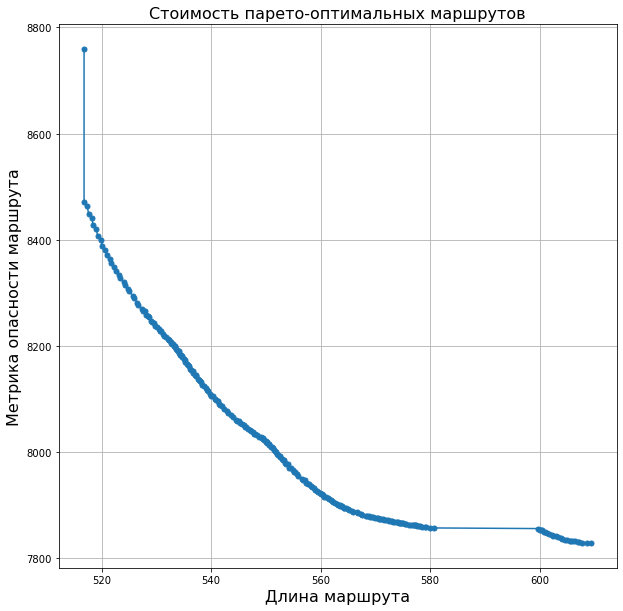

In [32]:
distances, dangers = list(zip(*result["costs"]))
plt.figure(figsize=(10, 10))
plt.plot(distances, dangers, markersize=5, marker='o')
plt.xlabel('Длина маршрута', fontsize=16)
plt.ylabel('Метрика опасности маршрута', fontsize=16)
plt.title('Стоимость парето-оптимальных маршрутов', fontsize=16)
plt.grid()